Difference from train_myocardium.ipynb: Solve the fiber evolution equation as an ODE rather than doing NR in every time step.

In [2]:
from jax.config import config
config.update('jax_disable_jit', True)
config.update('jax_enable_x64', True)
# config.update("jax_debug_nans", True)

import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from jax.lax import scan, cond
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
import pandas as pd
key = random.PRNGKey(0)

from utils_hyperelasticity import NODE_nobias
from utils import yprime_biaxial, getsigma
from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5 as mysolver

from utils import sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_RG_vmap, dPhi_vmap, plot45

In [3]:
def fibertau(stretches, F_params, useNODE):
    lm1,lm2,lm3,lm_i_F = stretches
    Psi_eq_params, Psi_neq_params, visc_params = F_params
    theta, fiber_visc_params = visc_params

    P = np.array([np.cos(theta), np.sin(theta), 0.0]) # In-plane fiber
    M = np.outer(P,P) 
    F = np.array([[lm1, 0, 0],
                  [0, lm2, 0],
                  [0, 0, lm3]])
    C = np.dot(F.T, F)
    lm_F = np.sqrt(np.tensordot(C, M, axes=2))

    lm_e_F = lm_F/lm_i_F
    I4e_F = lm_e_F**2
    I4_F = lm_F**2

    I4e_pr = np.max(np.array([0.0, I4e_F])) #no stress in fiber if compressive
    I4_pr = np.max(np.array([0.0, I4_F])) #no stress in fiber if compressive

    if useNODE:
        tau_F_neq = 2*NODE_nobias(I4e_pr-1.0, Psi_neq_params)*I4e_F
        tau_F_eq  = 2*NODE_nobias(I4_pr-1.0, Psi_eq_params)*I4_F
    else:
        k_neq = Psi_neq_params
        tau_F_neq = k_neq*(np.exp(I4e_pr-1.0)-1.0)*I4e_F # Just a generic holzapfel-like term for I4
        k_eq = Psi_eq_params
        tau_F_eq = k_eq*(np.exp(I4_pr-1.0)-1.0)*I4_F
    return tau_F_neq + tau_F_eq

def fiberCauchy(stretches, F_params, useNODE):
    lm1,lm2,lm3,lm_i_F = stretches
    J = lm1*lm2*lm3
    tau = fibertau(stretches, F_params, useNODE)

    Psi_eq_params, Psi_neq_params, visc_params = F_params
    theta, fiber_visc_params = visc_params

    P = np.array([np.cos(theta), np.sin(theta), 0.0]) # In-plane fiber
    M = np.outer(P,P) 
    F = np.array([[lm1, 0, 0],
                  [0, lm2, 0],
                  [0, 0, lm3]])
    C = np.dot(F.T, F)
    m = np.dot(F, np.dot(M, F.T))/np.tensordot(C, M, axes=2)
    return 1.0/J*tau*m
fiberCauchy_vmap = vmap(fiberCauchy, in_axes = (0, None, None), out_axes = 0)
dsigma33 = grad(lambda stretches, F_params, useNODE: fiberCauchy(stretches, F_params, useNODE)[2,2])

def lmiF_dot(stretches, F_params, useNODE):
    Psi_eq_params, Psi_neq_params, visc_params = F_params
    theta, fiber_visc_params = visc_params
    lm1, lm2, lm3, lm_i_F = stretches
    
    tau_NEQ_F = fibertau(stretches, F_params, useNODE)
    if useNODE:
        lmiFdot = lm_i_F*NODE_nobias(tau_NEQ_F, fiber_visc_params)
    else:
        eta_F = fiber_visc_params
        lmiFdot = lm_i_F*tau_NEQ_F/eta_F
    return lmiFdot

def yprime_fiber(t, y, lm1dot, lm2dot, tpeak, F_params, norm, useNODE):
    lm1, lm2, lm3, lm_i_F = y
    true_fun  = lambda t: np.array([lm1dot, lm2dot])
    false_fun = lambda t: np.array([   0.0,    0.0], dtype='float64')
    lm1dot, lm2dot = cond(t<tpeak, true_fun, false_fun, t) #since this is stress relaxation, lm1dot and lm2dot will be constant up to some point then zero

    lmiFdot = lmiF_dot(y, F_params, useNODE)

    d = dsigma33([lm1, lm2, lm3, lm_i_F], F_params, useNODE)
    lm3dot = -(d[0]*lm1dot + d[1]*lm2dot + d[3]*lmiFdot)/d[2]
    # Ordinarily this would give me lm3dot. However, my material fiber direction vector is in-plane, m[2,2] = 0 and therefore sigma[2,2] = 0 all the time.
    # This means d[2] = partial sigma / partial lm3 = 0 and results in lm3dot = 0/0 = nan. And this is expected, I shouldnt be doing this when I have an 
    # in-plane vector. So instead, I will just assign lm3dot = 0. 
    lm3dot = np.array(0.0)
    return lm1dot, lm2dot, lm3dot, lmiFdot

In [4]:
@partial(jit, static_argnums=(1,2,))
def biaxial_relax_aniso(params, norm, useNODE, time, lm1, lm2, dt0=0.5):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak

    M_params, F_params = params
    
    # Matrix part (identical to what we currently have)
    yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,M_params,norm,useNODE))
    term = ODETerm(yprime)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=dt0, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()
    sgm_M = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], M_params, norm, useNODE)

    # Fiber part
    solver = mysolver()
    yprime = lambda t, y, args: np.array(yprime_fiber(t,y,lm1dot,lm2dot,tpeak,F_params,norm,useNODE))
    term = ODETerm(yprime)
    y0 = np.array([1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=dt0, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm_i_F = solution.ys.transpose()
    sgm_F = fiberCauchy_vmap([lm1,lm2,lm3,lm_i_F], F_params, useNODE)
    
    sgm = sgm_F + sgm_M
    
    return sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e, lm_i_F


In [5]:
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 


# Define loss functions
def biaxial_relax_loss(params, norm, useNODE, inp, out):
    sigma_pr,_,_,_,_,_,_,_ = biaxial_relax_aniso(params, norm, useNODE, inp[0], inp[1], inp[2])
    loss = np.mean((sigma_pr[:,0,0]-out[0])**2 + (sigma_pr[:,1,1]-out[1])**2)
    return loss
biaxial_relax_loss_vmap = vmap(biaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
biaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(biaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.mean((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.mean((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.mean((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.mean((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.mean((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.mean((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

NODE_nobias_vmap = vmap(NODE_nobias, in_axes=(0, None), out_axes=0)
def Psi_F_loss(params, norm, useNODE, I4, k):
    gt = k*(np.exp(I4-1.0)-1.0)
    pr = 2*NODE_nobias_vmap(I4-1.0, params)
    return np.mean((gt-pr)**2)

def Phi_F_loss(params, norm, useNODE, tau, eta_F):
    gt = tau/eta_F
    pr = NODE_nobias_vmap(tau, params)
    return np.mean((gt-pr)**2)

In [51]:
with open('training_data/myocardium/Stress relaxation/combined.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
inp = np.array([time, lmb_x, lmb_y]).transpose([1,0,2])
out = np.array([sgm_x, sgm_y]).transpose([1,0,2])

mu = 21.0
K = 1.0
RG_Psi_eq_params = (K, mu)
RG_Psi_neq_params = (K, mu)

eta_D = 5000.0
eta_V = 50000.0
RG_Phi_params = (np.log(eta_D*0.1), np.log(eta_V*0.1))

RG_M_params = (RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params)

k_EQ = 4.0e-1
k_NEQ = 1.0e-1
theta = 0.0
eta_F = 20.0
visc_params = (theta, eta_F) #theta, eta_F
RG_F_params = (k_EQ, k_NEQ, visc_params)
RG_params = (RG_M_params, RG_F_params)
RG_norm = (1.0, 1.0, 1.0)


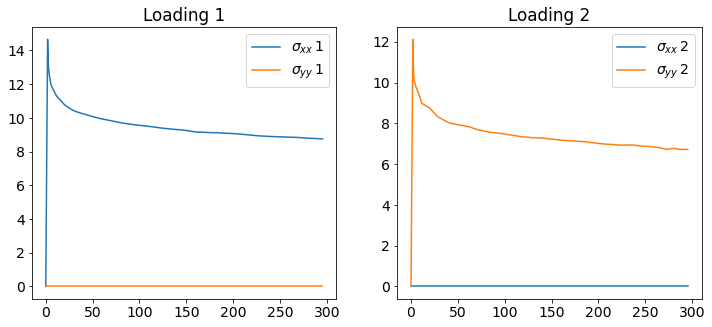

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(time[0], sgm_x[0], label='$\sigma_{xx} \, 1$')
ax[0].plot(time[0], sgm_y[0], label='$\sigma_{yy} \, 1$')
ax[0].set(title='Loading 1')

ax[1].plot(time[0], sgm_x[1], label='$\sigma_{xx} \, 2$')
ax[1].plot(time[0], sgm_y[1], label='$\sigma_{yy} \, 2$')
ax[1].set(title='Loading 2')

ax[0].legend()
ax[1].legend()

In [53]:
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)

(<matplotlib.legend.Legend at 0x2866c0820>,
 <matplotlib.legend.Legend at 0x28953f640>)

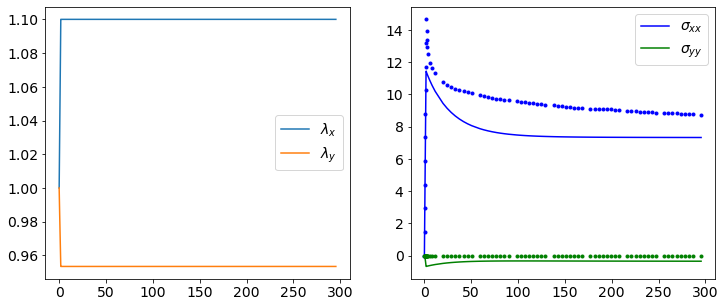

In [54]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_pr,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(RG_params, RG_norm, False, time[0], lmb_x[0], lmb_y[0])
t = inp[0,0]
ax[1].plot(t, sgm_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(t, sgm_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(t, sgm_x[0], 'b.')
ax[1].plot(t, sgm_y[0], 'g.')

ax[0].plot(t, inp[0,1], label='$\lambda_x$')
ax[0].plot(t, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

(<matplotlib.legend.Legend at 0x28aa8f6d0>,
 <matplotlib.legend.Legend at 0x28ad6be80>)

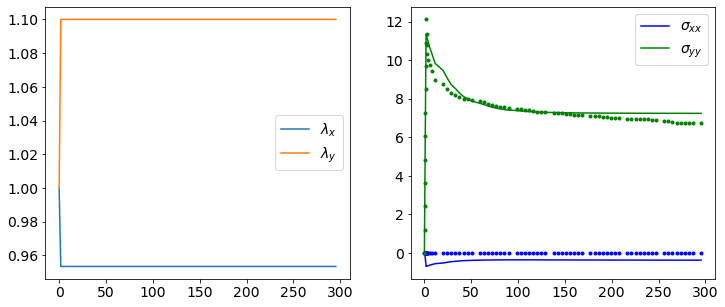

In [56]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_pr,lm1,lm2,lm3,_,_,_,lm_i_F= biaxial_relax_aniso(RG_params, RG_norm, False, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sgm_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

In [57]:
lr = 1.0e-3 #Set to 5.0e-4 if this doesn't work.
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(RG_params)

RG_params, train_loss, val_loss = train(inp, out, RG_norm, False, opt_state, key, biaxial_relax_batch_loss, nIter = 20000, batch_size=2, print_freq=100)
with open('saved/myocardium_RG_params.npy', 'wb') as f:
    pickle.dump(RG_params, f)

it 0, train loss = 1.700594e+00
it 100, train loss = 1.199235e+00
it 200, train loss = 1.101702e+00
it 300, train loss = 1.039011e+00
it 400, train loss = 9.933297e-01
it 500, train loss = 9.586275e-01
it 600, train loss = 9.300409e-01
it 700, train loss = 9.044338e-01
it 800, train loss = 8.802580e-01
it 900, train loss = 8.568706e-01
it 1000, train loss = 8.340791e-01
it 1100, train loss = 8.118630e-01
it 1200, train loss = 7.902475e-01
it 1300, train loss = 7.692590e-01
it 1400, train loss = 7.489118e-01
it 1500, train loss = 7.292072e-01
it 1600, train loss = 7.101343e-01
it 1700, train loss = 6.916728e-01
it 1800, train loss = 6.737951e-01
it 1900, train loss = 6.564688e-01
it 2000, train loss = 6.396581e-01
it 2100, train loss = 6.233263e-01
it 2200, train loss = 6.074366e-01
it 2300, train loss = 5.919539e-01
it 2400, train loss = 5.768454e-01
it 2500, train loss = 5.620819e-01
it 2600, train loss = 5.476375e-01
it 2700, train loss = 5.334906e-01
it 2800, train loss = 5.196236e-

(<matplotlib.legend.Legend at 0x2ab2adf00>,
 <matplotlib.legend.Legend at 0x1459f8d00>)

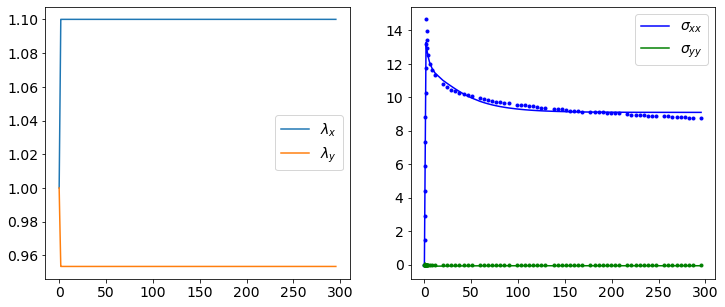

In [60]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(RG_params, RG_norm, False, inp[0,0], inp[0,1], inp[0,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[0], 'b.')
ax[1].plot(time, sgm_y[0], 'g.')

ax[0].plot(time, inp[0,1], label='$\lambda_x$')
ax[0].plot(time, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

(<matplotlib.legend.Legend at 0x2aabf9c90>,
 <matplotlib.legend.Legend at 0x2acbb0580>)

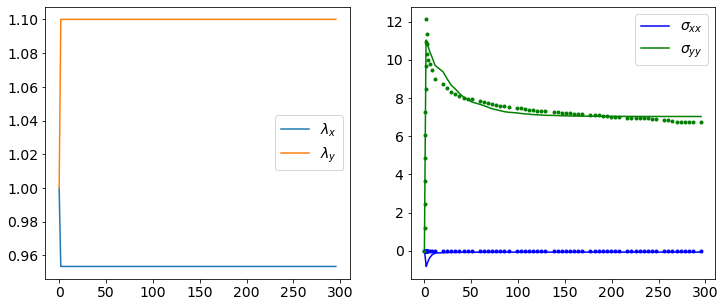

In [61]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(RG_params, RG_norm, False, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

In [63]:
# Train Psi_EQ and Psi_NEQ of matrix
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_M_params

In [64]:
lmb_z = 1/(lmb_x.flatten()*lmb_y.flatten())
lmb = np.transpose(np.array([lmb_x.flatten(), lmb_y.flatten(), lmb_z]))
lmb = lmb[::2]

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_eq_params)
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_eq_params
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
    
with open('saved/myocardium_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 9.887645e-01
it 10000, train loss = 6.625570e-03
it 20000, train loss = 3.951313e-03
it 30000, train loss = 2.035467e-03
it 40000, train loss = 7.848841e-04
it 50000, train loss = 1.559231e-04
it 60000, train loss = 1.579145e-05
it 70000, train loss = 7.694795e-06
it 80000, train loss = 7.407133e-06
it 90000, train loss = 7.269158e-06
it 100000, train loss = 7.030214e-06
it 110000, train loss = 6.907735e-06
it 120000, train loss = 6.857698e-06
it 130000, train loss = 6.628594e-06
it 140000, train loss = 7.164731e-06
it 150000, train loss = 6.442869e-06
it 160000, train loss = 6.295402e-06
it 170000, train loss = 6.111289e-06
it 180000, train loss = 6.096581e-06
it 190000, train loss = 5.963976e-06
it 200000, train loss = 5.712468e-06


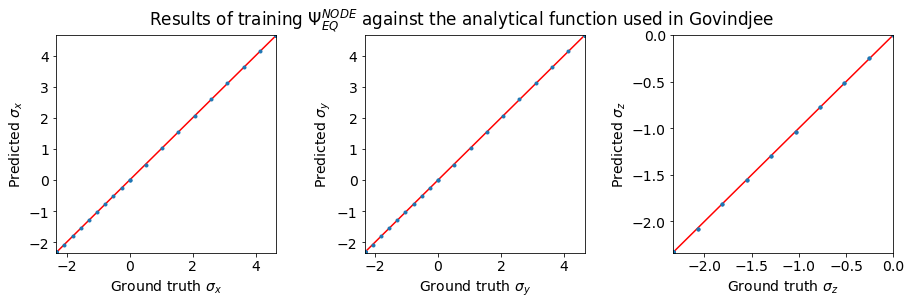

In [65]:
sigma_pr = sigma_split_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), RG_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

In [66]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
K, mu = RG_Psi_neq_params
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias, K)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/myocardium_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 1.048202e-01
it 10000, train loss = 5.128528e-03
it 20000, train loss = 1.468334e-03
it 30000, train loss = 6.800270e-04
it 40000, train loss = 2.146310e-04
it 50000, train loss = 3.369626e-05
it 60000, train loss = 6.252078e-06
it 70000, train loss = 5.597636e-06
it 80000, train loss = 5.438955e-06
it 90000, train loss = 5.402153e-06
it 100000, train loss = 5.265340e-06
it 110000, train loss = 5.078168e-06
it 120000, train loss = 5.032854e-06
it 130000, train loss = 3.357715e-06
it 140000, train loss = 1.663902e-06
it 150000, train loss = 7.219341e-07
it 160000, train loss = 3.045593e-07
it 170000, train loss = 1.460707e-07
it 180000, train loss = 1.033186e-07
it 190000, train loss = 9.150581e-08
it 200000, train loss = 8.902326e-08


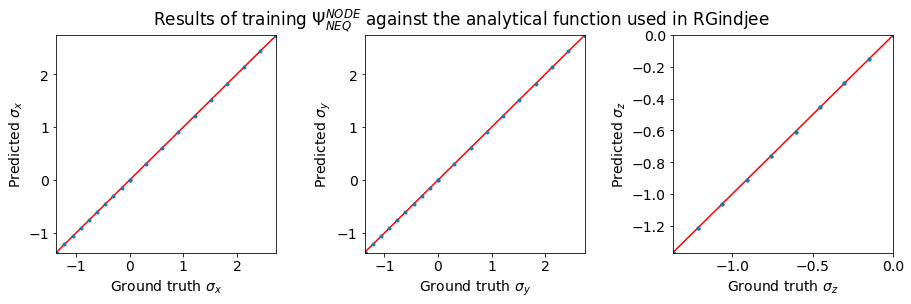

In [67]:
sigma_pr = sigma_split_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lmb_x.flatten(), lmb_y.flatten(), lmb_z.flatten(), RG_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in RGindjee"
plot45(gts, prs, labels, title)

In [68]:
# Train Phi
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_M_params
eta_D, eta_V = RG_Phi_params

In [69]:
# Generate training data
# Input data and normalization factors
r = 1.0
taui = onp.mgrid[-r:r:10j, -r:r:10j, -r:r:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

# inp_std1 = onp.std(tau1)
# inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

# out_std1 = 1.0
# out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/onp.exp(eta_V)
out_std5 = 1/3/onp.exp(eta_D)
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [70]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 200000, batch_size=100, print_freq=10000)

with open('saved/myocardium_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/myocardium_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.449021e+00
it 10000, train loss = 5.897942e-02
it 20000, train loss = 1.653900e-03
it 30000, train loss = 7.120551e-05
it 40000, train loss = 3.843704e-06
it 50000, train loss = 2.805246e-07
it 60000, train loss = 3.921482e-08
it 70000, train loss = 1.286492e-08
it 80000, train loss = 6.896956e-09
it 90000, train loss = 4.549378e-09
it 100000, train loss = 3.324404e-09
it 110000, train loss = 2.590673e-09
it 120000, train loss = 2.095491e-09
it 130000, train loss = 1.750431e-09
it 140000, train loss = 1.496993e-09
it 150000, train loss = 1.307638e-09
it 160000, train loss = 1.151399e-09
it 170000, train loss = 1.027940e-09
it 180000, train loss = 9.355594e-10
it 190000, train loss = 8.470860e-10
it 200000, train loss = 7.741495e-10


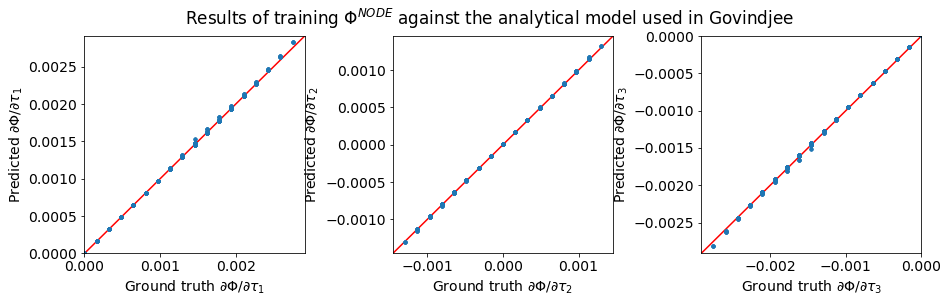

In [71]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

In [72]:
# Train Psi_EQ_F
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
k_EQ, k_NEQ, visc_params = RG_F_params

In [73]:
Psi_EQ_F_params = init_params_nobias(layers, key)
inp = np.linspace(1,3)
k = np.ones_like(inp)*k_EQ

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_EQ_F_params)
Psi_EQ_F_params, train_loss, val_loss = train(inp, k, None, False, opt_state, key, Psi_F_loss, nIter = 200000, batch_size=50, print_freq=10000)
with open('saved/myocardium_Psi_EQ_F_params.npy', 'wb') as f:
    pickle.dump(Psi_EQ_F_params, f)

it 0, train loss = 2.003041e+02
it 10000, train loss = 7.401422e-01
it 20000, train loss = 2.207857e-01
it 30000, train loss = 1.441913e-01
it 40000, train loss = 1.121076e-01
it 50000, train loss = 9.540466e-02
it 60000, train loss = 8.599641e-02
it 70000, train loss = 8.041586e-02
it 80000, train loss = 7.639126e-02
it 90000, train loss = 7.371508e-02
it 100000, train loss = 7.169039e-02
it 110000, train loss = 7.007988e-02
it 120000, train loss = 6.872938e-02
it 130000, train loss = 6.875826e-02
it 140000, train loss = 6.652284e-02
it 150000, train loss = 6.557858e-02
it 160000, train loss = 6.470561e-02
it 170000, train loss = 6.389595e-02
it 180000, train loss = 6.313556e-02
it 190000, train loss = 6.241971e-02
it 200000, train loss = 6.173872e-02


In [74]:
k = np.ones_like(inp)*k_NEQ

Psi_NEQ_F_params = init_params_nobias(layers, key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_NEQ_F_params)
Psi_NEQ_F_params, train_loss, val_loss = train(inp, k, None, False, opt_state, key, Psi_F_loss, nIter = 200000, batch_size=50, print_freq=10000)
with open('saved/myocardium_Psi_NEQ_F_params.npy', 'wb') as f:
    pickle.dump(Psi_NEQ_F_params, f)

it 0, train loss = 5.746423e+01
it 10000, train loss = 4.820701e-02
it 20000, train loss = 1.305157e-02
it 30000, train loss = 1.224514e-02
it 40000, train loss = 1.159128e-02
it 50000, train loss = 1.110110e-02
it 60000, train loss = 1.063071e-02
it 70000, train loss = 1.028213e-02
it 80000, train loss = 9.992677e-03
it 90000, train loss = 9.746674e-03
it 100000, train loss = 9.535162e-03
it 110000, train loss = 9.349522e-03
it 120000, train loss = 9.184069e-03
it 130000, train loss = 9.035852e-03
it 140000, train loss = 8.901322e-03
it 150000, train loss = 8.778058e-03
it 160000, train loss = 8.664594e-03
it 170000, train loss = 8.559243e-03
it 180000, train loss = 8.555208e-03
it 190000, train loss = 8.369293e-03
it 200000, train loss = 8.282652e-03


In [75]:
# Train Phi_F
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_M_params, RG_F_params = RG_params
k_EQ, k_NEQ, visc_params = RG_F_params
theta, eta_F = visc_params

In [76]:
inp = np.linspace(-1,+1)
eta_F = np.ones_like(inp)*eta_F

fiber_visc_params = init_params_nobias(layers, key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(fiber_visc_params)
fiber_visc_params, train_loss, val_loss = train(inp, eta_F, None, False, opt_state, key, Phi_F_loss, nIter = 200000, batch_size=50, print_freq=10000)
with open('saved/myocardium_fiber_visc_params.npy', 'wb') as f:
    pickle.dump(fiber_visc_params, f)

it 0, train loss = 3.718839e+01
it 10000, train loss = 1.885919e-05
it 20000, train loss = 1.896579e-07
it 30000, train loss = 8.605731e-08
it 40000, train loss = 3.989916e-10
it 50000, train loss = 2.325983e-09
it 60000, train loss = 1.909805e-12
it 70000, train loss = 1.264113e-10
it 80000, train loss = 1.884058e-12
it 90000, train loss = 3.865979e-12
it 100000, train loss = 1.859264e-12
it 110000, train loss = 1.846802e-12
it 120000, train loss = 1.834605e-12
it 130000, train loss = 1.822504e-12
it 140000, train loss = 1.810474e-12
it 150000, train loss = 1.838998e-12
it 160000, train loss = 1.831472e-12
it 170000, train loss = 4.781726e-10
it 180000, train loss = 1.763008e-12
it 190000, train loss = 1.751381e-12
it 200000, train loss = 1.739796e-12


In [77]:
M_params = (Psi_eq_params, Psi_neq_params, Phi_params)
Phi_F_params = (theta, fiber_visc_params)
F_params = (Psi_EQ_F_params, Psi_NEQ_F_params, Phi_F_params)
params = (M_params, F_params)
with open('saved/myocardium_params.npy', 'wb') as f:
    pickle.dump(params, f)
norm = (None, None, Phi_norm)

#### Retrain

In [11]:
with open('saved/myocardium_RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
with open('saved/myocardium_params.npy', 'rb') as f:
    params = pickle.load(f)
with open('saved/myocardium_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
norm = (None, None, Phi_norm)

with open('training_data/myocardium/Stress relaxation/combined.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)
inp = np.array([time, lmb_x, lmb_y]).transpose([1,0,2])
out = np.array([sgm_x, sgm_y]).transpose([1,0,2])

(<matplotlib.legend.Legend at 0x2ce6cb190>,
 <matplotlib.legend.Legend at 0x2d80e1990>)

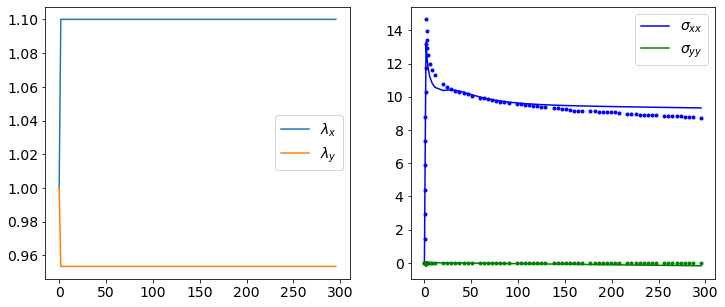

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(params, norm, True, inp[0,0], inp[0,1], inp[0,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[0], 'b.')
ax[1].plot(time, sgm_y[0], 'g.')

ax[0].plot(time, inp[0,1], label='$\lambda_x$')
ax[0].plot(time, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

(<matplotlib.legend.Legend at 0x14c72a110>,
 <matplotlib.legend.Legend at 0x14c8c4940>)

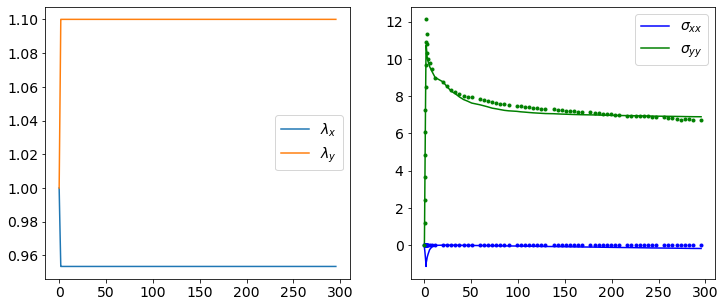

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sigma_pr,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(params, norm, True, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sigma_pr[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sigma_pr[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

In [13]:
lr = 1.0e-4 
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, biaxial_relax_batch_loss, nIter = 7000, batch_size=2, print_freq=20)
with open('saved/myocardium_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

it 0, train loss = 1.663583e-01
it 20, train loss = 1.251820e-01
it 40, train loss = 1.118382e-01
it 60, train loss = 1.058389e-01
it 80, train loss = 1.023076e-01
it 100, train loss = 9.999337e-02
it 120, train loss = 9.837407e-02
it 140, train loss = 9.716977e-02
it 160, train loss = 9.621508e-02
it 180, train loss = 9.543599e-02
it 200, train loss = 9.476611e-02
it 220, train loss = 9.417915e-02
it 240, train loss = 9.365333e-02
it 260, train loss = 9.317594e-02
it 280, train loss = 9.273852e-02
it 300, train loss = 9.232540e-02
it 320, train loss = 9.193809e-02
it 340, train loss = 9.156918e-02
it 360, train loss = 9.122083e-02
it 380, train loss = 9.088785e-02
it 400, train loss = 9.056628e-02
it 420, train loss = 9.026294e-02
it 440, train loss = 8.996322e-02
it 460, train loss = 8.968010e-02
it 480, train loss = 8.940157e-02
it 500, train loss = 8.913309e-02
it 520, train loss = 8.887055e-02
it 540, train loss = 8.861789e-02
it 560, train loss = 8.837224e-02
it 580, train loss =

RG MAE  0.17960359745669713
RG MRE  0.018401948658197935
NODE MAE  0.13414424734383787
NODE MRE  0.016763342724283817


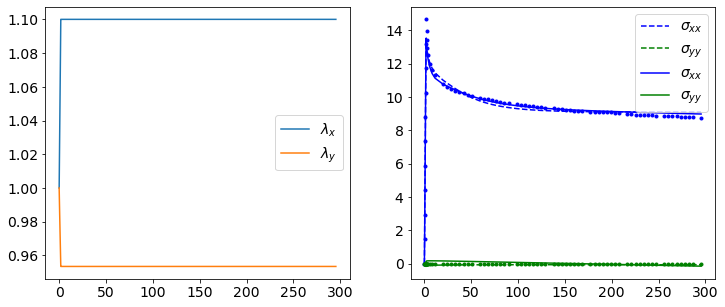

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_rg,lm1,lm2,lm3,_,_,_,lm_F_v = biaxial_relax_aniso(RG_params, norm, False, inp[0,0], inp[0,1], inp[0,2])
sgm_nn,lm1,lm2,lm3,_,_,_,lm_F_v = biaxial_relax_aniso(params, norm, True, inp[0,0], inp[0,1], inp[0,2])
time = inp[0,0]
ax[1].plot(time, sgm_rg[:,0,0], 'b--', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_rg[:,1,1], 'g--', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_nn[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_nn[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[0], 'b.')
ax[1].plot(time, sgm_y[0], 'g.')

ax[0].plot(time, inp[0,1], label='$\lambda_x$')
ax[0].plot(time, inp[0,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

# Save for TikZ
header = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(np.array([time, sgm_x[0], sgm_nn[:,0,0], sgm_rg[:,0,0]], dtype=np.float16).T, columns=header)
df.to_csv('tikz_data/fig_myocardium1/fig_myocardium1_a.csv', index=False, sep=' ')

print('RG MAE ', np.mean(np.abs(sgm_rg[:,0,0]-sgm_x[0])))
print('RG MRE ', np.mean((np.abs(sgm_rg[1:,0,0]-sgm_x[0,1:])/sgm_x[0,1:])))

print('NODE MAE ', np.mean(np.abs(sgm_nn[:,0,0]-sgm_x[0])))
print('NODE MRE ', np.mean((np.abs(sgm_nn[1:,0,0]-sgm_x[0,1:])/sgm_x[0,1:])))

RG MAE  0.21382993729516567
RG MRE  0.027561125761387407
NODE MAE  0.13623084212354525
NODE MRE  0.020136352636864686


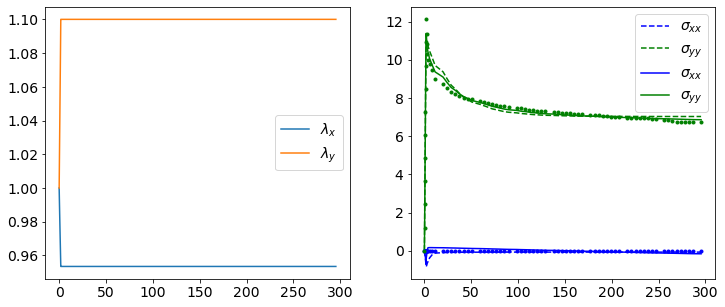

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sgm_rg,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(RG_params, norm, False, inp[1,0], inp[1,1], inp[1,2])
sgm_nn,lm1,lm2,lm3,_,_,_,lm_i_F = biaxial_relax_aniso(params, norm, True, inp[1,0], inp[1,1], inp[1,2])
time = inp[0,0]
ax[1].plot(time, sgm_rg[:,0,0], 'b--', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_rg[:,1,1], 'g--', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_nn[:,0,0], 'b-', label='$\sigma_{xx}$')
ax[1].plot(time, sgm_nn[:,1,1], 'g-', label='$\sigma_{yy}$')
ax[1].plot(time, sgm_x[1], 'b.')
ax[1].plot(time, sgm_y[1], 'g.')

ax[0].plot(time, inp[1,1], label='$\lambda_x$')
ax[0].plot(time, inp[1,2], label='$\lambda_y$')
ax[0].legend(), ax[1].legend()

# Save for TikZ
header = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(np.array([time, sgm_y[1], sgm_nn[:,1,1], sgm_rg[:,1,1]], dtype=np.float16).T, columns=header)
df.to_csv('tikz_data/fig_myocardium1/fig_myocardium1_b.csv', index=False, sep=' ')


print('RG MAE ', np.mean(np.abs(sgm_rg[:,1,1]-sgm_y[1])))
print('RG MRE ', np.mean((np.abs(sgm_rg[1:,1,1]-sgm_y[1,1:])/sgm_y[1,1:])))

print('NODE MAE ', np.mean(np.abs(sgm_nn[:,1,1]-sgm_y[1])))
print('NODE MRE ', np.mean((np.abs(sgm_nn[1:,1,1]-sgm_y[1,1:])/sgm_y[1,1:])))

In [17]:
print('RG MRE')
0.5*(0.018401948658197935 + 0.027561125761387407)

RG MRE


0.022981537209792673

In [18]:
print('NODE MRE')
0.5*(0.016763342724283817 + 0.020136352636864686)

NODE MRE


0.01844984768057425